In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.lines as lines
import numpy as np
from six.moves import cPickle as pickle
import json
from tqdm import tqdm

In [60]:
# VG
dir_path = 'Outputs/vg_X-101-64x4d-FPN/'

In [61]:
topk_dets_file = os.path.join(dir_path, 'rel_detection_range_0_6612.pkl')
with open(topk_dets_file, 'rb') as f:
    topk_dets = pickle.load(f)

In [62]:
print(len(topk_dets))
print(topk_dets[0].keys())
print(topk_dets[0]['obj_boxes'].shape)
print(topk_dets[0]['sbj_boxes'].shape)
min_len = 100
for det in topk_dets:
    if min_len > det['prd_scores'].shape[0]:
        min_len = det['prd_scores'].shape[0]
print(min_len)

6612
dict_keys(['sbj_boxes', 'sbj_labels', 'sbj_scores', 'obj_boxes', 'obj_labels', 'obj_scores', 'prd_scores', 'prd_scores_ttl', 'prd_scores_bias', 'prd_scores_spt', 'image', 'gt_sbj_boxes', 'gt_sbj_labels', 'gt_obj_boxes', 'gt_obj_labels', 'gt_prd_labels'])
(3686, 4)
(3686, 4)
58


In [8]:
# VG
img_path = 'data/vg/VG_100K/'
with open('data/vg/objects.json') as f:
    obj_cats = json.load(f)
with open('data/vg/predicates.json') as f:
    prd_cats = json.load(f)

In [3]:
def box_overlap(box1, box2):
    overlap = 0.0
    box_area = (
        (box2[2] - box2[0] + 1) *
        (box2[3] - box2[1] + 1)
    )
    iw = (
        min(box1[2], box2[2]) -
        max(box1[0], box2[0]) + 1
    )
    if iw > 0:
        ih = (
            min(box1[3], box2[3]) -
            max(box1[1], box2[1]) + 1
        )
        if ih > 0:
            ua = float(
                (box1[2] - box1[0] + 1) *
                (box1[3] - box1[1] + 1) +
                box_area - iw * ih
            )
            overlap = iw * ih / ua
    return overlap

# box1 and box2 are in [x1, y1. w. h] format
def box_union(box1, box2):
    xmin = min(box1[0], box2[0])
    ymin = min(box1[1], box2[1])
    xmax = max(box1[0] + box1[2] - 1, box2[0] + box2[2] - 1)
    ymax = max(box1[1] + box1[3] - 1, box2[1] + box2[3] - 1)
    return [xmin, ymin, xmax - xmin + 1, ymax - ymin + 1]

def box2rect(img, box):
    x = box[0] + edge_width / 2
    y = box[1] + edge_width / 2
    w = box[2] - box[0] - edge_width
    h = box[3] - box[1] - edge_width
    return x, y, w, h

In [6]:
def argsort_desc(scores):
    """
    Returns the indices that sort scores descending in a smart way
    :param scores: Numpy array of arbitrary size
    :return: an array of size [numel(scores), dim(scores)] where each row is the index you'd
             need to get the score.
    """
    return np.column_stack(np.unravel_index(np.argsort(-scores.ravel()), scores.shape))
def convert_rel_to_topk(rel_dict, prd_k, topk):
    det_boxes_sbj = rel_dict['sbj_boxes']  # (#num_rel, 4)
    det_boxes_obj = rel_dict['obj_boxes']  # (#num_rel, 4)
    det_labels_sbj = rel_dict['sbj_labels']  # (#num_rel,)
    det_labels_obj = rel_dict['obj_labels']  # (#num_rel,)
    det_scores_sbj = rel_dict['sbj_scores']  # (#num_rel,)
    det_scores_obj = rel_dict['obj_scores']  # (#num_rel,)
    if 'prd_scores_ttl' in rel_dict:
        det_scores_prd = rel_dict['prd_scores_ttl'][:, 1:]
    else:
        det_scores_prd = rel_dict['prd_scores'][:, 1:]

    det_labels_prd = np.argsort(-det_scores_prd, axis=1)
    det_scores_prd = -np.sort(-det_scores_prd, axis=1)

    det_scores_so = det_scores_sbj * det_scores_obj
    det_scores_spo = det_scores_so[:, None] * det_scores_prd[:, :prd_k]
    det_scores_inds = argsort_desc(det_scores_spo)[:topk]
    det_scores_top = det_scores_spo[det_scores_inds[:, 0], det_scores_inds[:, 1]]
    det_boxes_so_top = np.hstack(
        (det_boxes_sbj[det_scores_inds[:, 0]], det_boxes_obj[det_scores_inds[:, 0]]))
    det_labels_p_top = det_labels_prd[det_scores_inds[:, 0], det_scores_inds[:, 1]]
    det_labels_spo_top = np.vstack(
        (det_labels_sbj[det_scores_inds[:, 0]], det_labels_p_top, det_labels_obj[det_scores_inds[:, 0]])).transpose()

    det_boxes_s_top = det_boxes_so_top[:, :4]
    det_boxes_o_top = det_boxes_so_top[:, 4:]
    det_labels_s_top = det_labels_spo_top[:, 0]
    det_labels_p_top = det_labels_spo_top[:, 1]
    det_labels_o_top = det_labels_spo_top[:, 2]

    return dict(image=rel_dict['image'],
                      det_boxes_s_top=det_boxes_s_top,
                      det_boxes_o_top=det_boxes_o_top,
                      det_labels_s_top=det_labels_s_top,
                      det_labels_p_top=det_labels_p_top,
                      det_labels_o_top=det_labels_o_top,
                      det_scores_top=det_scores_top)

    

In [4]:
with open('Sakura.jpeg.pkl', 'rb') as handle:
    myimage = pickle.load(handle)
    
myimage["image"] = "Sakura.jpeg"
myimage.keys()

dict_keys(['sbj_boxes', 'sbj_labels', 'sbj_scores', 'obj_boxes', 'obj_labels', 'obj_scores', 'prd_scores', 'prd_scores_ttl', 'prd_scores_bias', 'prd_scores_spt', 'image'])

In [33]:
with open('./Outputs/imat_9999test/rel_detections.pkl', 'rb') as handle:
    myimage = pickle.load(handle)

with open('./data/imaterialist/predicates.json') as f:
    prd_cats = json.load(f)
with open('./data/imaterialist/objects.json') as f:
    obj_cats = json.load(f)
myimage = myimage[0]
myimage["image"] = "DSC08303-1200x1200.jpg"


"""
with open('./Outputs/imat_att_test/rel_detections.pkl', 'rb') as handle:
    myimage = pickle.load(handle)

with open('./data/imaterialist/predicates_attributes.json') as f:
    prd_cats = json.load(f)
with open('./data/imaterialist/objects.json') as f:
    obj_cats = json.load(f)
myimage = myimage[0]
myimage["image"] = "DSC08303-1200x1200.jpg"
"""

'\nwith open(\'./Outputs/imat_att_test/rel_detections.pkl\', \'rb\') as handle:\n    myimage = pickle.load(handle)\n\nwith open(\'./data/imaterialist/predicates_attributes.json\') as f:\n    prd_cats = json.load(f)\nwith open(\'./data/imaterialist/objects.json\') as f:\n    obj_cats = json.load(f)\nmyimage = myimage[0]\nmyimage["image"] = "DSC08303-1200x1200.jpg"\n'

image:  DSC08303-1200x1200.jpg
topk:  10
sbj_labels.shape[0]:  10
jacket
jacket
shirt, blouse
jacket
shirt, blouse
shirt, blouse
shirt, blouse
jacket
jacket
jacket


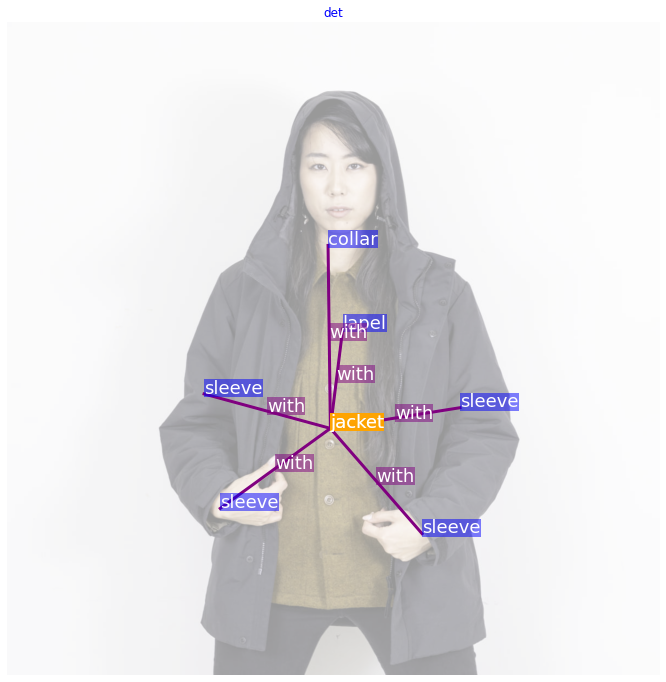

0: jacket with sleeve
		total score:	 0.608933
1: jacket with sleeve
		total score:	 0.608340
2: shirt, blouse with sleeve
		total score:	 0.345436
3: jacket with lapel
		total score:	 0.341944
4: shirt, blouse with sleeve
		total score:	 0.322755
5: shirt, blouse with sleeve
		total score:	 0.290246
6: shirt, blouse with sleeve
		total score:	 0.286723
7: jacket with sleeve
		total score:	 0.264571
8: jacket with collar
		total score:	 0.262064
9: jacket with sleeve
		total score:	 0.233317


In [39]:
edge_width = 3
font_size = 18
topk = 10 #50  # 100
score_thr = 0.05  # 0.05

save_output = False

#ind = np.random.randint(0, len(topk_dets))
#print('ind: ', ind)
#det = convert_rel_to_topk(topk_dets[ind],10, topk)

det = convert_rel_to_topk(myimage,10, topk)
img_path = "./data/imaterialist/test/"


sbj_boxes = det['det_boxes_s_top']
sbj_labels = det['det_labels_s_top']
obj_boxes = det['det_boxes_o_top']
obj_labels = det['det_labels_o_top']
prd_labels = det['det_labels_p_top']
det_scores = det['det_scores_top']

img_name = det['image'].split('/')[-1]
print('image: ', img_name)
print('topk: ', topk)
print('sbj_labels.shape[0]: ', sbj_labels.shape[0])

img = mpimg.imread(img_path + img_name)

fig = plt.figure(figsize=(18, 12))
ax = plt.gca()
plt.imshow(img,alpha=0.4)
plt.axis('off')
det_title = plt.title('det')
plt.setp(det_title, color='b')
for j in range(min(topk, sbj_labels.shape[0])):
    # det
    det_score = det_scores[j]
    if det_score < score_thr:
        continue
    
    sbj_label = sbj_labels[j]
    obj_label = obj_labels[j]
    prd_label = prd_labels[j]
    sbj_box = sbj_boxes[j]
    obj_box = obj_boxes[j]
    s_name = obj_cats[sbj_label]
    o_name = obj_cats[obj_label]
    p_name = prd_cats[prd_label]
    print(s_name)
    if s_name != "jacket":
        continue
    
    s_x, s_y, s_w, s_h = box2rect(img, sbj_box)
    s_cx = s_x + s_w // 2
    s_cy = s_y + s_h // 2
    ax.text(s_cx, s_cy - 2,
            s_name,
            fontsize=font_size,
            color='white',
            bbox=dict(facecolor='orange', alpha=0.5, pad=0, edgecolor='none'))
    
    o_x, o_y, o_w, o_h = box2rect(img, obj_box)
    o_cx = o_x + o_w // 2
    o_cy = o_y + o_h // 2
    ax.text(o_cx, o_cy - 2,
            o_name,
            fontsize=font_size,
            color='white',
            bbox=dict(facecolor='blue', alpha=0.5, pad=0, edgecolor='none'))
    
    rel_l = lines.Line2D([s_cx, o_cx], [s_cy, o_cy], color='purple', linewidth=edge_width)
    ax.add_line(rel_l)
    ax.text((s_cx + o_cx) / 2, (s_cy + o_cy) / 2,
            p_name,
            fontsize=font_size,
            color='white',
            bbox=dict(facecolor='purple', alpha=0.5, pad=0, edgecolor='none'))

if save_output:
    output_dir = os.path.join(dir_path, img_id)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.savefig(os.path.join(output_dir, 'all_true_pos.jpg'), bbox_inches='tight')
plt.show()
plt.close(fig)

# print names and scores
for j in range(min(topk, sbj_labels.shape[0])):
    # det
    det_score = det_scores[j]
    if det_score < score_thr:
        continue
    sbj_label = sbj_labels[j]
    obj_label = obj_labels[j]
    prd_label = prd_labels[j]
    s_name = obj_cats[sbj_label]
    o_name = obj_cats[obj_label]
    p_name = prd_cats[prd_label]
    print('{}: {} {} {}'.format(j, s_name, p_name, o_name))
    print('\t\ttotal score:\t {:.6f}'.format(det_score))

In [71]:
import pickle
with open('../Large-Scale-VRD.pytorch/Outputs/imat/bbox_imaterialist_test_mini_results.json', 'rb') as handle:
    fashion_detection = json.load(handle)



with open('./data/imaterialist/detection_test.json', 'rb') as handle:
    detection_test = json.load(handle)
imat_cat = {cat['id']:cat['name'] for cat in detection_test["categories"]}

image:  DSC08303-1200x1200.jpg
2
[260.53765869140625, 341.68536376953125, 668.1417236328125, 811.9574584960938]
2
[377.43505859375, 1044.3201904296875, 495.731689453125, 155.6798095703125]
2
[491.0290832519531, 125.6077880859375, 255.82742309570312, 273.0352783203125]
2
[437.2324523925781, 327.1514892578125, 306.4657897949219, 166.6976318359375]
2
[406.17437744140625, 375.24755859375, 423.41455078125, 379.3043212890625]
2
[366.8680114746094, 844.8992309570312, 50.06353759765625, 98.25341796875]
2
[288.16387939453125, 439.3242492675781, 148.15020751953125, 488.8420104980469]
2
[736.301025390625, 888.4358520507812, 55.0357666015625, 105.47705078125]
2
[729.9906005859375, 430.6528625488281, 206.199951171875, 557.1563415527344]


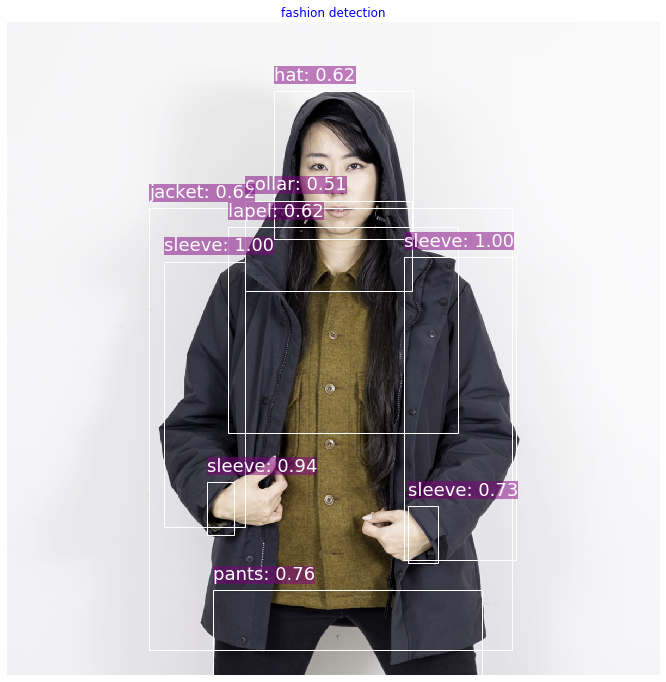

In [76]:
font_size=18
save_output = False
threshold = 0.5



img_path = "./data/imaterialist/test/"

img_name = "DSC08303-1200x1200.jpg"
image_id=2
print('image: ', img_name)


img = mpimg.imread(img_path + img_name)

fig = plt.figure(figsize=(18, 12))
ax = plt.gca()
plt.imshow(img)
plt.axis('off')
det_title = plt.title('fashion detection')
plt.setp(det_title, color='b')

for detection in fashion_detection:
    if detection["score"] < threshold:
        continue
    if detection["image_id"] != image_id:
        continue
    print(detection["image_id"] )    
    bbox = detection["bbox"]
    print(bbox)
    rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='w',facecolor='none')
    
    ax.add_patch(rect)

    
    ax.text(bbox[0],bbox[1]-20,
            imat_cat[detection["category_id"]]+": "+"{:.2f}".format(detection["score"]),
            fontsize=font_size,
            color='white',
            bbox=dict(facecolor='purple', alpha=0.5, pad=0, edgecolor='none'))

if save_output:
    output_dir = os.path.join(dir_path, img_id)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.savefig(os.path.join(output_dir, 'all_true_pos.jpg'), bbox_inches='tight')
plt.show()
plt.close(fig)



image:  Sakura.jpeg


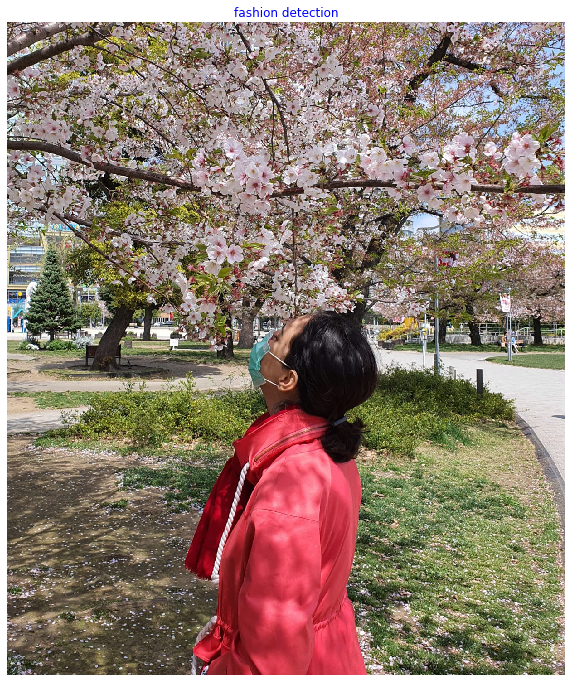

826 395 1427 792


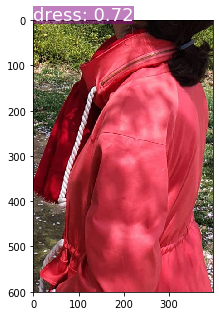

881 397 1322 580


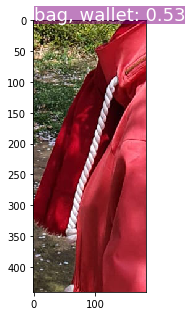

938 680 1354 780


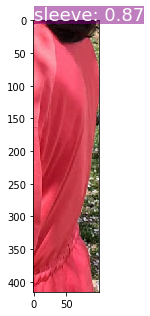

943 397 1213 533


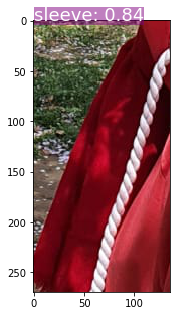

In [36]:
font_size=18
save_output = False
threshold = 0.5


img_path = "./"

img_name = "Sakura.jpeg"
print('image: ', img_name)


img = mpimg.imread(img_path + img_name)

fig = plt.figure(figsize=(18, 12))
ax = plt.gca()
plt.imshow(img)
plt.axis('off')
det_title = plt.title('fashion detection')
plt.setp(det_title, color='b')
plt.show()

for detection in fashion_detection:
    if detection["score"] < threshold:
        continue
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()
    
    bbox = detection["bbox"]
    
    x1,y1,x2,y2 = int(bbox[1]), int(bbox[0]), int(bbox[1]) + int(bbox[3]) ,  int(bbox[0]) + int(bbox[2])
    print(x1,y1,x2,y2)
    cropped = img[x1:x2, y1:y2, :]
    plt.imshow(cropped)
    
    ax.text(0,0,
            imat_cat[detection["category_id"]]+": "+"{:.2f}".format(detection["score"]),
            fontsize=font_size,
            color='white',
            bbox=dict(facecolor='purple', alpha=0.5, pad=0, edgecolor='none'))
    plt.show()

if save_output:
    output_dir = os.path.join(dir_path, img_id)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.savefig(os.path.join(output_dir, 'all_true_pos.jpg'), bbox_inches='tight')
plt.show()
plt.close(fig)



In [49]:
import pickle
with open('./rel_annotations_attributes_train.json', 'rb') as handle:
    temp = json.load(handle)
